In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv


In [2]:
np.random.seed(42)

# Table of Contents

* [0. Data Collection & Feature Definitions](#chapter0)
    * [0.1 Initial Descriptions & Metrics of Data](#chapter0_1)
    * [0.2 Initial Observations of Features](#chapter0_2)
* [1. Initial Predictions & Model Testing](#chapter1)
    * [1.1 Build Lists for Features](#chapter1_1)
    * [1.2 Build out Initial Functions to Fit and Score Models](#chapter1_2)

## 0. Data Collection & Feature Definitions <a class="anchor" id="chapter0"></a>

|Columns|Definition|
|----------|----------|
|id|Unique Identifier|
|date|Date string in YYYY-MM-DD format|
|country|String of countries|
|store|String of store names|
|product|String Product name being bought|
|num_sold|Number values for the count of product sold|

### 0.1 Initial Descriptions & Metrics of Data <a class="anchor" id="chapter0_1"></a>

In [3]:
df = pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,230130.0,115064.500000,66432.953062,0.0,57532.25,115064.5,172596.75,230129.0
num_sold,221259.0,752.527382,690.165445,5.0,219.00,605.0,1114.00,5939.0


In [4]:
df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


The above shows that the majority of the columns used for analysis is categorical functions.

In [5]:
def get_inferred_type(column):
    if pd.api.types.is_object_dtype(column):
        sample_value = column.dropna().iloc[0]
        return type(sample_value).__name__
    else:
        return column.dtype

def comparison_table(df):
    return pd.DataFrame({
        'Data Type':df.apply(get_inferred_type),
        'Missing Values':df.isna().sum(),
        'Unique Values':df.nunique()
    })

comp_table = comparison_table(df) # the variable will be used later

with pd.option_context('display.max_rows',None,'display.max_columns',None):
    print(comp_table)

         Data Type  Missing Values  Unique Values
id           int64               0         230130
date           str               0           2557
country        str               0              6
store          str               0              3
product        str               0              5
num_sold   float64            8871           4037


In [6]:
len(df)

230130

the main label `num_sold` is the only column that have missing values, which means it would probably be better to just remove the data from the dataset as without label data the rows will not have any benefit for training. Since the training data has 230,130 rows of data, removing 8,871 rows (less than 10% of the total number) the training data should not be impacted too badly.

In [7]:
df = df.dropna(subset=['num_sold'])
comp_table = comparison_table(df)
comp_table

,Data Type,Missing Values,Unique Values
id,int64,0,221259
date,str,0,2557
country,str,0,6
store,str,0,3
product,str,0,5
num_sold,float64,0,4037


Also, it is important to recognize that there is a date variable that needs to be split up by year, month, and date to get more representative data.

In [8]:
df[['Year','Month','Day']] = df['date'].str.split('-',expand=True)
df = df.drop('date',axis=1)
comp_table = comparison_table(df)
comp_table

,Data Type,Missing Values,Unique Values
id,int64,0,221259
country,str,0,6
store,str,0,3
product,str,0,5
num_sold,float64,0,4037
Year,str,0,7
Month,str,0,12
Day,str,0,31


### 0.2 Initial Observations of Features <a class="anchor" id="chapter0_2"></a>

In [9]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

Since there are really no viable numerical features, we will have to rely on other ways to determine correlation patterns.

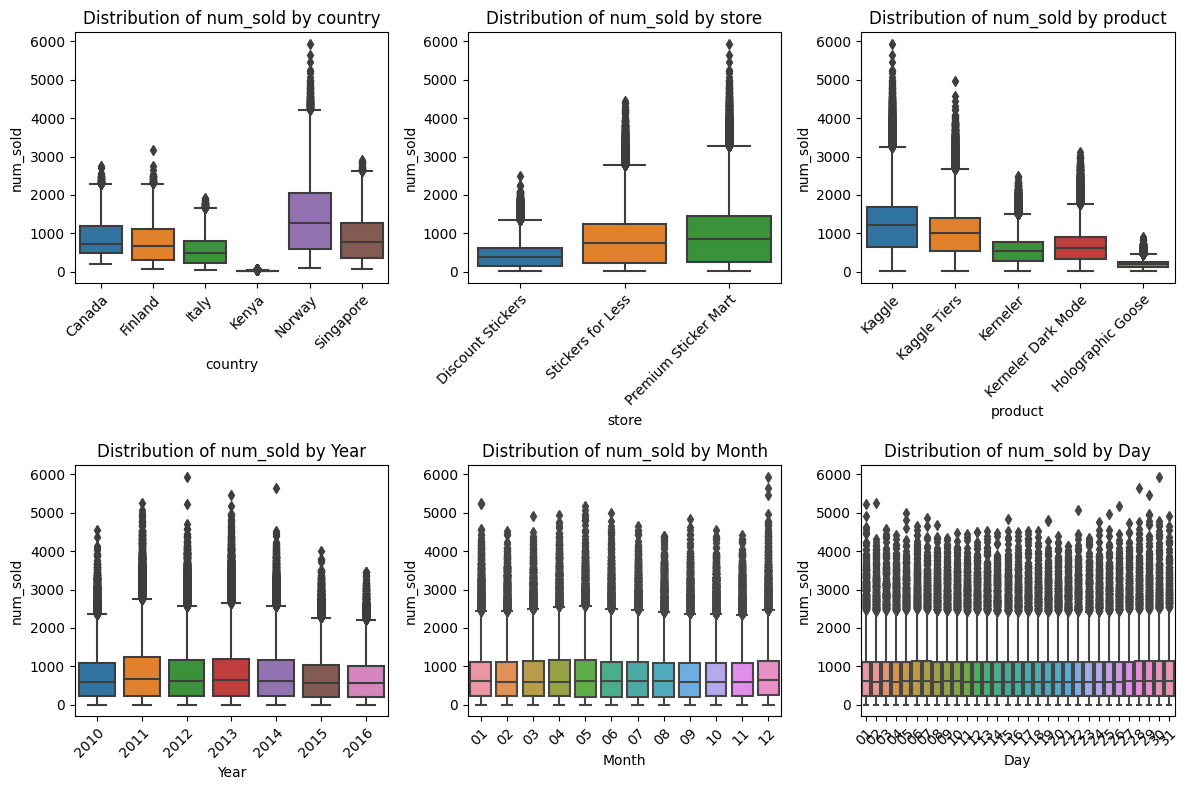

In [10]:
categorical_features = df.select_dtypes(include=['object']).columns
cols = 3
rows = math.ceil(len(categorical_features)/cols)

fig,axes = plt.subplots(rows,cols,figsize=(12,rows*4))
axes = axes.flatten()

for i,feature in enumerate(categorical_features):
    sns.boxplot(x=df[feature],y=df['num_sold'],ax=axes[i])
    axes[i].set_title(f"Distribution of num_sold by {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('num_sold')
    axes[i].set_xticklabels(axes[i].get_xticklabels(),rotation=45,ha='right',wrap=True)

for j in range(i+1,len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 1. Initial Predictions & Model Testing <a class="anchor" id="chapter1"></a>

In [11]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder,FunctionTransformer,PolynomialFeatures
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

### 1.1 Build Initial Lists for Features <a class="anchor" id="chapter1_1"></a>

In [12]:
# since there are no numerical values we will be testing, \
# at first at least we should just build out the categorical features list and pass that along
categorical_features = []

for feature in comp_table.index:
    if feature != 'id' and feature != 'num_sold':
        row = comp_table.loc[feature]
        if row['Data Type'] in ['str']:
            categorical_features.append(feature)

features = {
    'Categorical Features':categorical_features
}

features

{'Categorical Features': ['country',
  'store',
  'product',
  'Year',
  'Month',
  'Day']}

### 1.2 Build out Functions to Fit and Score Models <a class="anchor" id="chapter1_2"></a>

In [13]:
def make_pipeline(features,model_object):
    preprocessor = ColumnTransformer(transformers=[
        ('cat',Pipeline([
            ('imputer',SimpleImputer(strategy='most_frequent')),
            ('onehot',OneHotEncoder(drop='first',handle_unknown='ignore'))
        ]),features['Categorical Features'])
    ])
    return Pipeline(steps=[
        ('preprocessor',preprocessor),
        ('estimator',model_object)
    ])

In [14]:
abacuss = {
    'RandomForestRegressor_page':{
        'model':RandomForestRegressor(random_state=42)
    },
    'SGDRegressor_page':{
        'model':SGDRegressor(random_state=42)
    },
    'XGBRegressor_page':{
        'model':XGBRegressor(random_state=42)
    }
}

abacuss

{'RandomForestRegressor_page': {'model': RandomForestRegressor(random_state=42)},
 'SGDRegressor_page': {'model': SGDRegressor(random_state=42)},
 'XGBRegressor_page': {'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=42, ...)}}

In [15]:
X = df.drop('num_sold',axis=1)
y = df['num_sold']

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2)

(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

((177007, 7), (44252, 7), (177007,), (44252,))

In [16]:
model_scores = {}

def update_model_scores(
    pipeline,
    X_train,
    X_val,
    model_tag,
    model_scores=model_scores,
    tuned_tag='baseline'
):
    preds = pipeline.predict(X_val)
    model_scores.update({
        f'{model_tag} {tuned_tag}':{
            'accuracy':pipeline.score(X_val,y_val),
            'MAPE':mean_absolute_percentage_error(y_val,preds),
            'pipeline':pipeline
        }
    })
    return model_scores

In [17]:
for page in abacuss:
    pipeline = make_pipeline(features,abacuss[page]['model'])
    pipeline.fit(X_train,y_train)
    model_scores = update_model_scores(pipeline,X_train,X_val,page)

<Axes: >

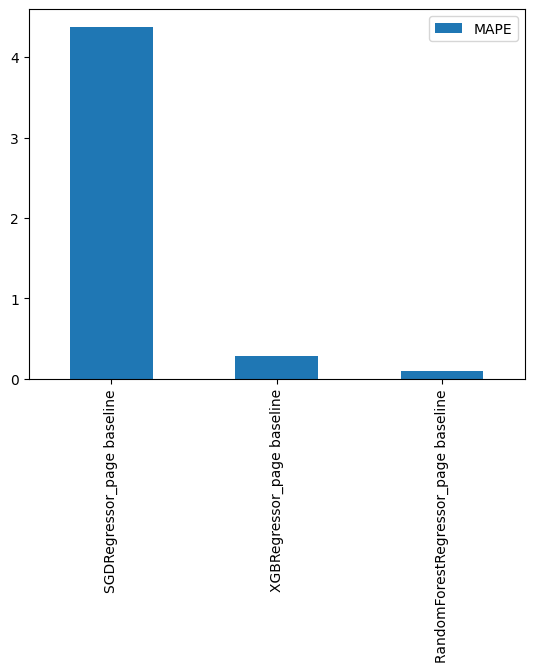

In [18]:
stat_to_map = 'MAPE'
model_compare = pd.DataFrame(model_scores,index=[stat_to_map])
model_compare.T.sort_values(stat_to_map,ascending=False).plot.bar()